### K-means implementation

In [131]:
import math, matplotlib.pyplot as plt, torch

from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [132]:
torch.manual_seed(9)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

#### create data

In [133]:
n_clusters = 6
n_samples = 250

centroids = torch.rand(n_clusters, 2)*60

In [134]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [135]:

slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [136]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

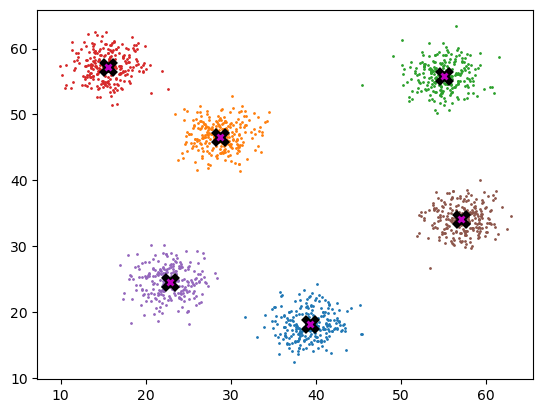

In [137]:
plot_data(centroids, data, n_samples)

#### K-means algorithm
1. select the number K to dicide the number of clusters
2. randomly choose K centroids
3. Assign each data point to its closest centroid to create K clusters
4. update each centroid to its cluster's center of gravity
5. repeat 3~4

#### Implementation

In [138]:
#1 select K, initialize assignment
K = 6
assignment = torch.zeros(data.shape[0])
assignment.shape

torch.Size([1500])

In [139]:
#2 randomely select K centroids
Cs = data[torch.randint(0, len(data), (K,))]
print(Cs)
Cs.shape

tensor([[56.427, 58.880],
        [20.865, 26.659],
        [39.541, 15.145],
        [50.342, 56.904],
        [57.094, 33.484],
        [57.853, 38.043]])


torch.Size([6, 2])

In [140]:
#3 assignn datapoints to their closest centroids
d = data[0]
print(d)
print(d.shape)

# calc distance to centroid
dist=((d - Cs)**2).sum(1).sqrt()
print(dist)
print(dist.shape)

# assignment
print(dist.argmin())

tensor([38.932, 18.782])
torch.Size([2])
tensor([43.748, 19.710,  3.688, 39.793, 23.366, 26.999])
torch.Size([6])
tensor(2)


In [141]:
# batch version

d = data[:5]
print(d)
print(d.shape)

# calc distance to centroid
dist=((d[:,None] - Cs[None])**2).sum(2).sqrt()
print(dist)
print(dist.shape)

# assignment
print(dist.argmin(1))
assignment[:5] = dist.argmin(dim=1)

tensor([[38.932, 18.782],
        [41.625, 17.823],
        [36.791, 19.975],
        [41.479, 18.780],
        [38.201, 16.750]])
torch.Size([5, 2])
tensor([[43.748, 19.710,  3.688, 39.793, 23.366, 26.999],
        [43.644, 22.563,  3.393, 40.042, 22.013, 25.927],
        [43.580, 17.272,  5.559, 39.337, 24.387, 27.750],
        [42.795, 22.069,  4.120, 39.140, 21.448, 25.281],
        [45.904, 19.968,  2.092, 41.950, 25.238, 28.975]])
torch.Size([5, 6])
tensor([2, 2, 2, 2, 2])


In [142]:
# update centroids
for C in range(K):
    Cs[C] = data[assignment==C].mean(0)
print(Cs)

tensor([[36.359, 39.536],
        [   nan,    nan],
        [39.405, 18.422],
        [   nan,    nan],
        [   nan,    nan],
        [   nan,    nan]])


In [143]:
# update centroids with na
Cs = data[torch.randint(0, len(data), (K,))]

for C in range(K):
    if (assignment==C).sum()>0:
        Cs[C] = data[assignment==C].mean(0)
print(Cs)

tensor([[36.359, 39.536],
        [57.389, 37.094],
        [39.405, 18.422],
        [20.091, 56.871],
        [57.291, 32.546],
        [23.068, 23.475]])


In [144]:
def kmeans(data, Cs=None, assignment=None, bs=50, K=6, iteration=10):
    n = len(data)

    # assignment
    if assignment is None: assignment = torch.zeros(data.shape[0])
    
    # initialize
    if Cs is None: Cs = data[torch.randint(0, len(data), (K,))]

    for it in range(iteration):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs,n))
            # print(s)
            # assignment
            assignment[s] = ((data[s][:,None] - Cs[None])**2).sum(2).sqrt().argmin(dim=1)
        for C in range(K):
            if (assignment==C).sum()>0:
                Cs[C] = data[assignment==C].mean(0)

    return Cs, assignment

In [145]:
def plot_data_kmeans(centroids, data, assignment, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[assignment==i]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

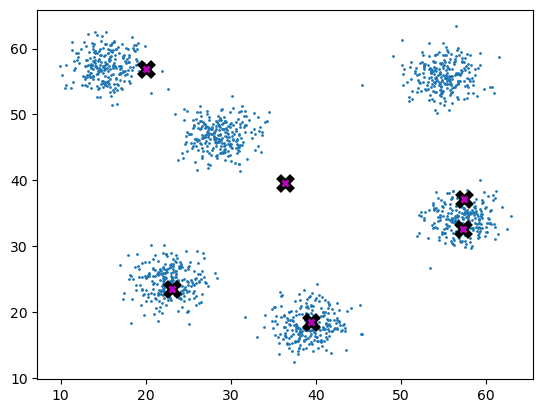

In [146]:
# initial
plot_data(Cs, data, len(data))

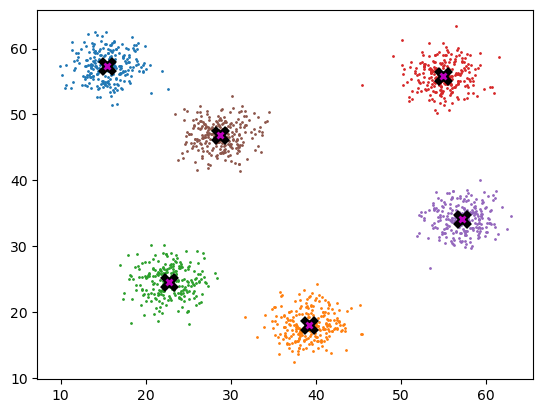

In [147]:
# after 5 iteration
test=kmeans(data, iteration=5)
plot_data_kmeans(test[0], data, test[1])

#### animation

In [148]:
def kmeans_one(data, bs=50):
    for i in range(0,n,bs):
        s = slice(i, min(i+bs,n))
        assignment[s] = ((data[s][:,None] - Cs[None])**2).sum(2).sqrt().argmin(dim=1)
    for C in range(K):
        if (assignment==C).sum()>0:
            Cs[C] = X[assignment==C].mean(0)

In [149]:
K = 6
Cs = data[torch.randint(0, len(X), (K,))]
assignment = torch.zeros(data.shape[0])
n = len(data)
def kmeans_one(data, bs=50):
    for i in range(0,n,bs):
        s = slice(i, min(i+bs,n))
        assignment[s] = ((data[s][:,None] - Cs[None])**2).sum(2).sqrt().argmin(dim=1)
    for C in range(K):
        if (assignment==C).sum()>0:
            Cs[C] = X[assignment==C].mean(0)

In [150]:
def do_one(d):
    if d: kmeans_one(X)
    ax.clear() # clear previous one
    plot_data_kmeans(Cs, X, assignment, ax=ax)

In [158]:
# create your own animation
torch.manual_seed(2)

K = 6
Cs = data[torch.randint(0, len(X), (K,))]
assignment = torch.zeros(data.shape[0])
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=15, interval=1000, repeat=False) #500ms interval
plt.close()
ani.save('kmeans.mp4')


In [159]:
from IPython.display import Video
Video('kmeans.mp4')


In [160]:
# create your own animation
torch.manual_seed(2)

K = 6
Cs = data[torch.randint(0, len(X), (K,))]
assignment = torch.zeros(data.shape[0])
n = len(data)
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=15, interval=1000, repeat=False) #500ms interval
plt.close()
HTML(ani.to_jshtml())